## Essentials

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import integrate
import pyccl as ccl

from fftlog import *

## Utility functions

In [2]:
def a2z(a):
    return 1. / a - 1

def z2a(z):
    return 1. / (z + 1)

def nz(z, a=1.0, b=2.0, z0=1.0):
    return 2 * z ** a * np.exp(-((z / z0) ** b))

## FFTLog

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.25,
                       Omega_b=0.05,
                       h=0.67, n_s=0.96,
                       sigma8=0.81)

## CCL

In [58]:
class LimberFFTLog(object):
    
    def __init__(self, cosmo, nz):
        self.cosmo = cosmo
        self.nz = nz
        self.H0 = self.cosmo['h'] * 100.0
        self.c = 299792.458 # km/s
        self.z = np.linspace(0.002, 4, 1000)
        self.chi = ccl.comoving_radial_distance(self.cosmo, z2a(self.z))
        self.chi = np.logspace(np.log10(np.min(self.chi)), np.log10(np.max(self.chi)), 1000)
        self.a = ccl.scale_factor_of_chi(self.cosmo, self.chi)
        self.bias = 1.0
        self.z = a2z(self.a)
        
    def Delta_Limber(self, k, ell):
        chi = (ell + 0.5) / k
        a = ccl.scale_factor_of_chi(self.cosmo, chi)
        z = a2z(a)
        delta_limber = ccl.h_over_h0(self.cosmo, a) * self.H0 / self.c * self.nz(z) * self.bias
        return delta_limber
    
    def Hankel(self, ell):
        kernel = ccl.h_over_h0(self.cosmo, self.a) * self.H0 / self.c * self.bias * self.nz(self.z)
        f = self.chi * kernel * ccl.growth_factor(self.cosmo, self.a)
        nu = 1.01
        myfftlog = FFTLog(self.chi, f, nu=nu, N_extrap_low=0, 
                            N_extrap_high=0, c_window_width=0.25, N_pad=0)
        k, F = myfftlog.fftlog(ell)
        return k, F
    
    
    def angular_cl(self, ells):
        def non_linear_integrand(k, ell):
            chi = (ell + 0.5) / k
            a = ccl.scale_factor_of_chi(self.cosmo, chi)
            return self.Delta_Limber(k, ell) ** 2 * ccl.nonlin_matter_power(self.cosmo, k, a)
        
        def non_linear(ell):
            kmin = (ell + 0.5) / np.max(self.chi)
            kmax = min(10.0, (ell + 0.5) / np.min(self.chi))
            cl = 1.0 / (ell + 0.5) * integrate.quad(non_linear_integrand, kmin, kmax, args=(ell,))[0]
            return cl
        
        def linear_integrand(ell):
            k, F = self.Hankel(ell)
            integrand = k ** 2 * ccl.linear_matter_power(self.cosmo, k, 1.0) * F ** 2
            return k, integrand
            
    
        def c_one(ell, use_limber=True):
            k, integrand = linear_integrand(ell)
            cl = 2.0 / np.pi * integrate.simps(integrand, k)
            
            if use_limber:
                cl += non_linear(ell)
            return cl
        
        result = np.array([c_one(ell) for ell in ells])
        return result

In [59]:
lfft = LimberFFTLog(cosmo, nz)

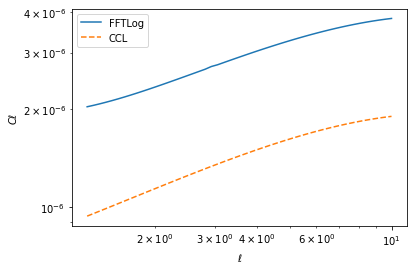

In [70]:
ells = np.logspace(0.1, 1)
z = np.linspace(0.002, 4, 1000)
tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz(z)), bias=(z, np.ones_like(z)))
cl_ccl = ccl.angular_cl(cosmo, tracer, tracer, ells)

plt.loglog(ells, lfft.angular_cl(ells), label='FFTLog')
plt.loglog(ells, cl_ccl, '--', label='CCL')
plt.xlabel('$\ell$')
plt.ylabel('$C\ell$')
plt.legend();

In [41]:
ells = np.logspace(0.1, 1)
z = np.linspace(0.002, 4, 1000)
tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz(z)), bias=(z, np.ones_like(z)))
cl_ccl = ccl.angular_cl(cosmo, tracer, tracer, ells, p_of_k_a=ccl.Pk2D(pkfunc=lambda k, a: ccl.nonlin_matter_power(cosmo, k, a)+ccl.linear_matter_power(cosmo, k, a),
                                                                  cosmo=cosmo, a_arr=z2a(z)))

plt.loglog(ells, lfft.angular_cl(ells), label='FFTLog')
plt.loglog(ells, cl_ccl, '--', label='CCL')
plt.xlabel('$\ell$')
plt.ylabel('$C\ell$')
plt.legend();

CCLError: Error CCL_ERROR_INTEG: ccl_cls.c: ccl_angular_cls_limber(); integration error


In [39]:
func = ccl.Pk2D(pkfunc=lambda k, a: ccl.nonlin_matter_power(cosmo, k, a) + ccl.linear_matter_power(cosmo, k, a), cosmo=cosmo)